## Extracting Monthly Humidity Data from Array

#### Author: Ryan Gan
#### Date: 2018-06-29

Extracting gridded atmospheric humidity values to North American region and regriding to study area. Dates appear to be every from 1980 to 2018.

In [1]:
# import dataset from netCDF as nc_open; array storage system
import netCDF4 as nc
# import dataset
from netCDF4 import Dataset 
# interpolate griddate
from scipy import interpolate
# import numpy as np; for working with array data
import numpy as np
# import pandas as pd; working with data.frames
import pandas as pd
# Matplotlib for additional customization
from matplotlib import pyplot as plt 
%matplotlib inline
#import mpl_toolkits # i'd like basemap but doesn't seem to be available for py3
# Seaborn for plotting and styling
import seaborn as sns

Open connection to humidity netcdf.

In [2]:
# open r humidity nc
rhum_nc = Dataset("../data/nc/rhum.mon.mean.nc")

Print out humidity variable information.

In [3]:
print(rhum_nc)
# print out details of each variable
for v in rhum_nc.variables:
    print(rhum_nc.variables[v])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 18:12:20 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/rhum.mon.mean.nc ./surface/rhum.mon.mean.nc
Mon Jul  5 23:49:27 1999: ncrcat ./rhum.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/rhum.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/rhum.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Thu Oct 26 23:42:16 1995 from pre.sig995.85.nc
created 95/02/06 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean rhum.sig995 from the NCEP Reanalysis
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html
    dataset_title: NCEP-NCAR Reanalysis 1
    dimensions(sizes): lat(73), 

### Extracting Grid Locations of Humidity Grid

Extracting humidity global grid.

In [4]:
# extract latitude
lat = rhum_nc.variables['lat'][:]
# extract longitude
lon = rhum_nc.variables['lon'][:]
# extract time
time = rhum_nc.variables['time'][:]
# 1st precipitation values
rhum = rhum_nc.variables['rhum'][1,:,:]
# check dimension of shape
np.shape(rhum)

(73, 144)

Print out min, mean, max of humidity vector.

In [5]:
print(np.min(rhum), np.mean(rhum), np.max(rhum))

0.25 78.968025 99.82758


Using Seaborn to print out a heatmap the first matrix of humidity. Look at all the dry areas in the desert and poles. Cool.

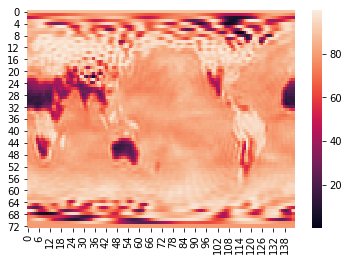

In [6]:
sns.heatmap(rhum)

I want to subset the array to the spatial extent of the continental United States.  The longitude bounds should be  -124.848974 to -66.885444. I will need to add 180 degrees to these degrees west to match the convert from degrees east of the nc file. The latitude bounds should be 24.396308 to 49.384358.

In [7]:
# lat and lon bounds
latbounds = [24.4, 49.4]
# lon bounds need to be converted from easterling to westerling to get US
lonbounds = [-124.8 + 360, -66.9 + 360]

# latitude lower and upper bounds
lat_ui = np.argmin(np.abs(lat - latbounds[0]))
lat_li = np.argmin(np.abs(lat - latbounds[1]))

# longitude lower and upper boudns
lon_li = np.argmin(np.abs(lon - lonbounds[0]))
lon_ui = np.argmin(np.abs(lon - lonbounds[1]))
# print index
print(lat_li, lat_ui, lon_li, lon_ui)

16 26 94 117


Subset latitude and longitude grid points.

In [8]:
# subset us lon
lon_us = lon[lon_li:lon_ui]-360
# subset us lat
lat_us = lat[lat_li:lat_ui]
# print dimensions
print(np.min(lon_us), np.max(lon_us), np.min(lat_us), np.max(lat_us))

-125.0 -70.0 27.5 50.0


Subset to US.

In [9]:
# subset temp to us
rhum_us = rhum_nc.variables['rhum'][1, lat_li:lat_ui, lon_li:lon_ui]
np.shape(rhum_us)

(10, 23)

Plot heatmap of US relative humidity to make sure subset looks right.

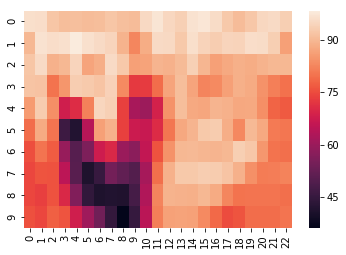

In [10]:
sns.heatmap(rhum_us)

### Binary Interpolation of Humidity to Finer Grid Resolution

Using interpolation to estimate humidity to a finer grid. Creating a 1x1 degree grid. I've done this before for other netcdf files and know it works so I'm going to go ahead and just interpolate for all grids.

In [11]:
# custom grids for every degree
# vectors
grid_lat = np.arange(24, 50.0, 1)
grid_lon = np.arange(-125.0, -66, 1)
# mesh grid array
glons, glats = np.meshgrid(grid_lon, grid_lat)

Plotting new grid to check shape.

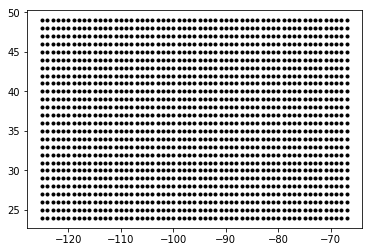

In [12]:
# plot new grid
plt.plot(glons, glats, marker='.', color='k', linestyle='none')
plt.show()

Set up interpoloation spline using RectBivariateSpline, which is faster than interp2D if it's a regular grid (which it is). Lats and Lons need to be sorted and the dimensions need to match shape of value array.

In [13]:
# extract full monthly grid
rhum_us_full = rhum_nc.variables['rhum'][:, lat_li:lat_ui, lon_li:lon_ui]

In [14]:
# check shape
np.shape(rhum_us_full)

(844, 10, 23)

In [15]:
# create empty numpy array of 843 days and 26 lat by 59 lat 
rhum_fine = np.zeros((844, 26, 59))

# interpolate for each month to new grid
for i in range(844):
    # extract prec element
    rhum_mon = rhum_us_full[i]
    # create interpolate 
    interp_spline = interpolate.RectBivariateSpline(sorted(lat_us), lon_us, rhum_mon)
    # interpolate to new grid
    rhum_fine[i] = interp_spline(grid_lat, grid_lon)

In [16]:
# check shape
np.shape(rhum_fine)

(844, 26, 59)

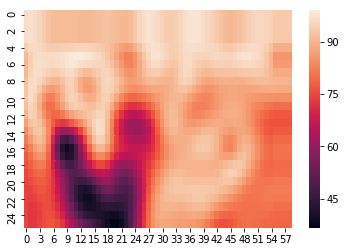

In [17]:
# view regrid humidity
check_rhum = rhum_fine[1]
sns.heatmap(check_rhum)

### Array to Dataframe

Flattening array and converting to pandas dataframe.

In [21]:
# coordinates to a 2 dimension array
us_grid = np.array(np.meshgrid(grid_lon, grid_lat)).reshape(2, -1).T
# check dimensions
np.shape(us_grid)

(1534, 2)

In [23]:
# extract precip array
us_rhum = rhum_fine.reshape(844,1534).T #.T is for transpose
# check shape
np.shape(us_rhum)

(1534, 844)

In [19]:
# create grid id
grid_id = np.arange(1, 1535,1)
grid_id_array = np.reshape(grid_id, (26,59))
grid_id_flat = grid_id_array.flatten()
# create grid id 1 to 1534 and save as type string
grid_id = pd.DataFrame(grid_id_flat).astype('str')
grid_id.columns = ['grid_id'] 
# head and tail
print(grid_id.head(), grid_id.tail())

  grid_id
0       1
1       2
2       3
3       4
4       5      grid_id
1529    1530
1530    1531
1531    1532
1532    1533
1533    1534


Binding/concatenating grid id variable with lon and lat coordinates.

In [24]:
# create grid dataframe from coordinate array
grid_df = pd.DataFrame(data = us_grid)
# name columns
grid_df.columns = ['glon', 'glat']
# concat dataframes
grid_df = pd.concat([grid_id, grid_df], axis=1)
# view first rows
grid_df.head()

,grid_id,glon,glat
0,1,-125.0,24.0
1,2,-124.0,24.0
2,3,-123.0,24.0
3,4,-122.0,24.0
4,5,-121.0,24.0


Assign Dates

In [25]:
from datetime import datetime
# extract date times from nc file; define units
date = nc.num2date(time, 'hours since 1800-01-01 00:00:0.0')
# ts
ts = pd.Series(date, index = date)
# view first couple observations
print(ts.head(), ts.tail())

1948-01-01   1948-01-01
1948-02-01   1948-02-01
1948-03-01   1948-03-01
1948-04-01   1948-04-01
1948-05-01   1948-05-01
dtype: datetime64[ns] 2017-12-01   2017-12-01
2018-01-01   2018-01-01
2018-02-01   2018-02-01
2018-03-01   2018-03-01
2018-04-01   2018-04-01
dtype: datetime64[ns]


Convert humidity array to dataframe.

In [26]:
# array to dataframe
rhum_df = pd.DataFrame(data = us_rhum)
# add name
rhum_df.columns = ts.dt.date
# concat grid id and temp
rhum_wide_df = pd.concat([grid_df, rhum_df], axis = 1)
rhum_wide_df.head()

,grid_id,glon,glat,1948-01-01,1948-02-01,1948-03-01,1948-04-01,1948-05-01,1948-06-01,1948-07-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
0,1,-125.0,24.0,97.338707,96.431038,95.483871,90.783333,91.145164,82.824333,85.096771,...,86.741936,82.370964,84.775002,90.048386,94.316666,91.782257,95.104836,90.080360,91.564514,91.166664
1,2,-124.0,24.0,98.211021,97.238527,96.234506,92.785824,91.548058,80.568577,81.774171,...,80.743154,74.755898,81.585779,90.768646,95.582047,94.013215,95.877072,91.514776,93.179626,91.436066
2,3,-123.0,24.0,97.709057,96.699276,96.257903,94.248077,92.000642,79.775199,78.980273,...,73.968836,67.271499,77.972554,90.720289,96.037858,95.296767,95.905474,92.224707,94.106103,91.379532
3,4,-122.0,24.0,96.325776,95.330348,95.796273,95.218251,92.439682,80.224767,76.767805,...,66.985037,60.312375,74.153107,89.785188,95.778479,95.624519,95.281628,92.167430,94.251637,90.984131
4,5,-121.0,24.0,94.554136,93.648808,95.091826,95.744506,92.801944,81.697845,75.189493,...,60.357815,54.273135,70.345219,87.845219,94.898290,94.988073,94.097124,91.300222,93.523919,90.236931


In [27]:
# wide to long
rhum_long_df = pd.melt(rhum_wide_df, id_vars = ['grid_id', 'glon', 'glat'],
                      var_name = "date", value_name = "rhum_perc")
# view head of final row-wise dataset
rhum_long_df.head()

,grid_id,glon,glat,date,rhum_perc
0,1,-125.0,24.0,1948-01-01,97.338707
1,2,-124.0,24.0,1948-01-01,98.211021
2,3,-123.0,24.0,1948-01-01,97.709057
3,4,-122.0,24.0,1948-01-01,96.325776
4,5,-121.0,24.0,1948-01-01,94.554136


In [28]:
# print min and max date
print(rhum_long_df['date'].min(), rhum_long_df['date'].max())

1948-01-01 2018-04-01


Saving long monthly relative humidity for regrided US grid to csv.

In [29]:
# commented out to not write again
#rhum_long_df.to_csv('../data/model_data/1948-2018_mon_rhum_us.csv')